Deleted existing collection: tobacco_report
Created new collection: tobacco_report
Generating Mixtral responses...
Mixtral responses have been saved to mixtral_responses.csv
Generating Llama responses...
Llama responses have been saved to llama_responses.csv
Evaluating responses...
Evaluations have been saved to response_evaluations.csv
Aggregating scores and determining the best model...
Mixtral Overall Score: 8.172222222222224
Llama Overall Score: 7.6499999999999995
Best Model: Mixtral
T-statistic: 3.334885311035385
P-value: 0.010309238110993229
Mean difference: 0.5222222222222221
Mixtral Average Scores: [8.2, 8.8, 7.1, 8.85, 7.95, 8.65, 7.75, 7.6, 8.65]
Llama Average Scores: [7.75, 7.55, 6.6, 8.65, 8.3, 8.35, 7.15, 6.9, 7.6]

Interpretation of Statistical Significance:
There is a statistically significant difference between the performance of Llama and Mixtral (p < 0.05).
Llama consistently outperformed Mixtral across the evaluated metrics.
The mean difference of 0.52 indicates the 

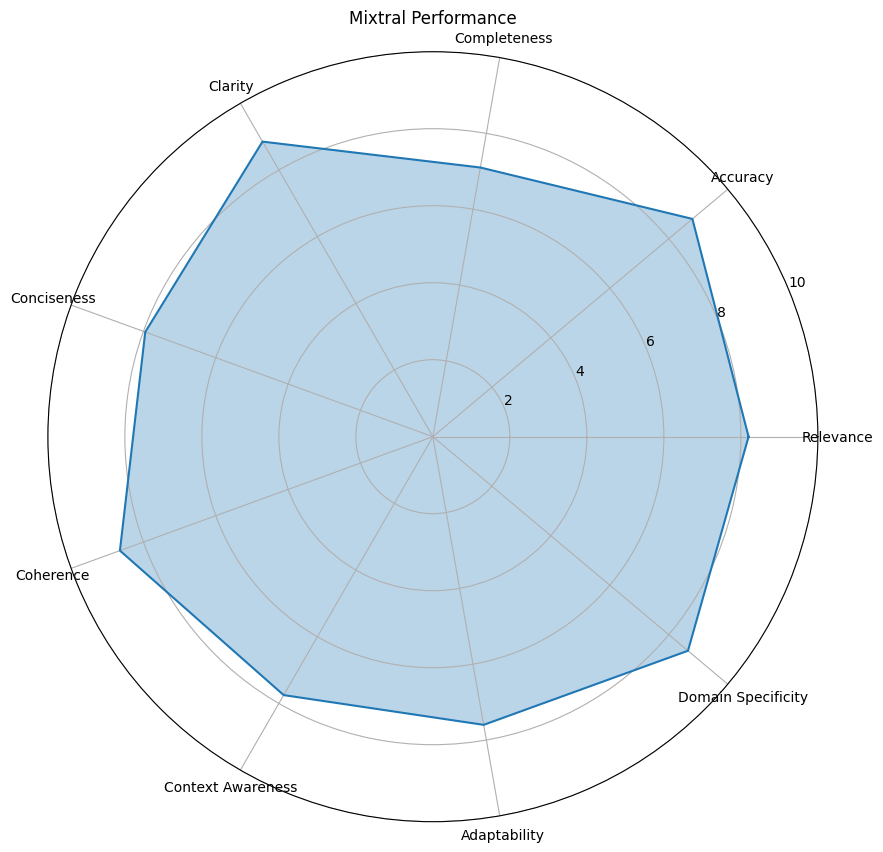

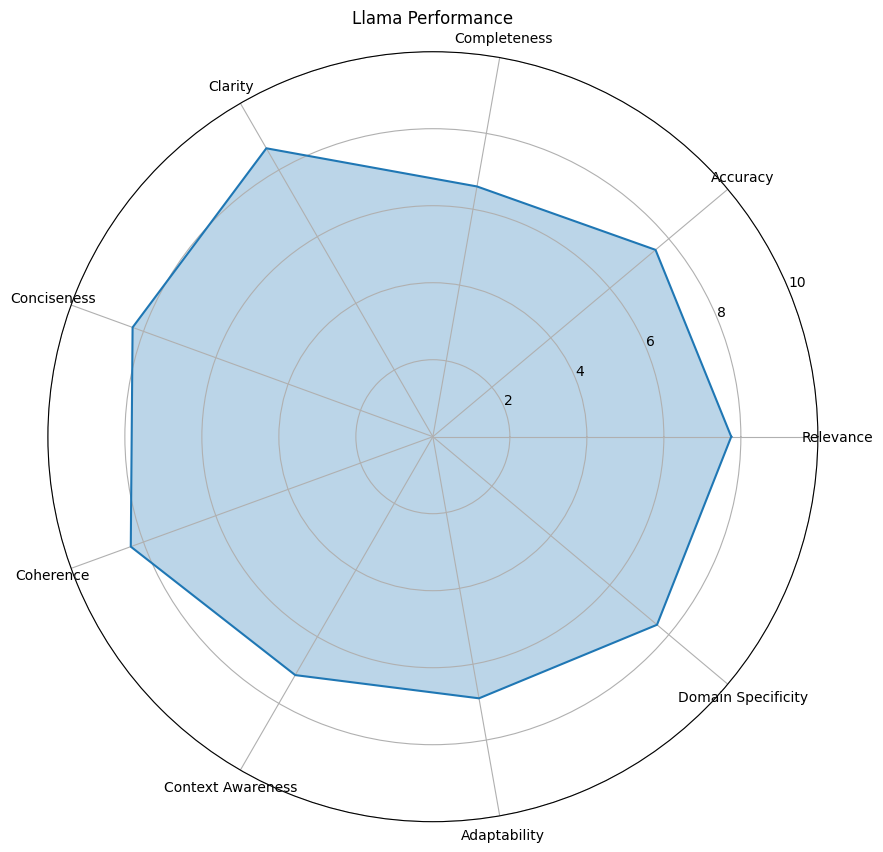

In [ ]:
!pip install pypdf
!pip install openai==0.28
!pip install chromadb
!pip install typing
!pip install sentence-transformers
!pip install transformers
!pip install deepinfra[openai]



import os
import re
import csv
import time
import random
import openai
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import torch
from typing import List
from pypdf import PdfReader
import chromadb
from sentence_transformers import SentenceTransformer
from chromadb.api.types import Documents, Embeddings, EmbeddingFunction

# Load the PDF file and extract text from each page
def load_pdf(file_path):
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text
    return text

# Split the text into chunks based on double newlines
def split_text(text):
    return [i for i in re.split('\n\n', text) if i.strip()]

# Define a custom embedding function using SentenceTransformer
class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    def __call__(self, input: Documents) -> Embeddings:
        return self.model.encode(input).tolist()

def create_chroma_db(documents: List[str], name: str):
    db_folder = "chroma_db"
    if not os.path.exists(db_folder):
        os.makedirs(db_folder)

    chroma_client = chromadb.PersistentClient(path=db_folder)

    existing_collections = chroma_client.list_collections()
    if name in [c.name for c in existing_collections]:
        chroma_client.delete_collection(name=name)
        print(f"Deleted existing collection: {name}")
        embedding_function = CustomEmbeddingFunction()
        db = chroma_client.create_collection(name=name, embedding_function=embedding_function)
        print(f"Created new collection: {name}")
    else:
        embedding_function = CustomEmbeddingFunction()
        db = chroma_client.create_collection(name=name, embedding_function=embedding_function)

    for i, d in enumerate(documents):
        db.add(documents=[d], ids=[str(i)])

    return db

# Retrieve the most relevant passages based on the query
def get_relevant_passage(query: str, db, n_results: int):
    results = db.query(query_texts=[query], n_results=n_results)
    return [doc[0] for doc in results['documents']]

# Function to generate response using DeepInfra
def generate_deepinfra_response(query: str, context: str, model_name: str, max_input_length=32767):
    prompt = f"Answer the following question based on the given context. Question: {query} Context: {context}"

    # Truncate the context if it exceeds the maximum input length
    if len(prompt) > max_input_length:
        prompt = prompt[:max_input_length]

    chat_completion = openai.ChatCompletion.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}],
    )
    return chat_completion.choices[0].message.content

# Function to read queries from CSV
def read_queries_from_csv(file_path):
    queries = []
    with open(file_path, 'r', newline='', encoding='utf-8-sig') as file:
        reader = csv.DictReader(file)
        for i, fieldname in enumerate(reader.fieldnames):
            if fieldname.startswith('\ufeff'):
                reader.fieldnames[i] = fieldname[len('\ufeff'):]
        if 'Query' not in reader.fieldnames:
            print(f"Error: 'Query' column not found in CSV. Available columns: {reader.fieldnames}")
            raise KeyError(f"'Query' column not found in CSV. Available columns: {reader.fieldnames}")
        for row in reader:
            queries.append(row['Query'])
    return queries

# Function to evaluate response using GPT-4
def evaluate_response(query, response):
    max_retries = 5
    base_delay = 60

    for attempt in range(max_retries):
        try:
            evaluation_prompt = f"""
            Evaluate the following response to the query based on the given criteria:

            Query: {query}
            Response: {response}

            Criteria:
            1. Relevance (0-10): How well does the response address the specific query?
            2. Accuracy (0-10): How factually correct and precise is the response?
            3. Completeness (0-10): Does the response provide a comprehensive answer covering all aspects of the query?
            4. Clarity (0-10): Is the response clear and easy to understand?
            5. Conciseness (0-10): Is the response brief yet informative, avoiding unnecessary details?
            6. Coherence (0-10): Is the response logically structured and coherent?
            7. Context Awareness (0-10): Does the response demonstrate understanding of the context within the document?
            8. Adaptability (0-10): How well does the response adapt to the nuances of the query?
            9. Domain Specificity (0-10): Does the response show specialized knowledge relevant to tobacco?

            Provide only the scores for each criterion, separated by commas, in the order listed above. Do not include any additional text, explanations, or the criteria numbers.
            """
            response = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are an evaluator that provides detailed feedback on query responses."},
                    {"role": "user", "content": evaluation_prompt}
                ],
                max_tokens=100
            )




            content = response['choices'][0]['message']['content']
            scores_str = re.findall(r'\d+(?:\.\d+)?', content)

            if len(scores_str) != 9:
                raise ValueError(f"Expected 9 scores, but got {len(scores_str)}")

            scores = [float(score) for score in scores_str]
            return scores
        except (openai.error.RateLimitError, openai.error.APIError) as e:
            if attempt < max_retries - 1:
                delay = base_delay * (2 ** attempt) + random.uniform(0, 10)
                print(f"Error occurred: {e}. Retrying in {delay:.2f} seconds...")
                time.sleep(delay)
            else:
                raise
        except ValueError as ve:
            print(f"Error processing scores: {ve}")
            print(f"Raw content: {content}")
            raise

# Main execution
if __name__ == "__main__":
    # Set OpenAI API key and base URL
    openai.api_key = "deepinfra_key"
    openai.api_base = "https://api.deepinfra.com/v1/openai"

    # Load and process the PDF
    pdf_path = "/content/pmi_report_2023.pdf"
    pdf_text = load_pdf(pdf_path)
    chunked_text = split_text(pdf_text)

    # Create the Chroma database
    db_name = "tobacco_report"
    db = create_chroma_db(chunked_text, db_name)

    # File paths
    input_csv = 'query_response_reference1.csv'
    mixtral_output_csv = 'mixtral_responses.csv'
    llama_output_csv = 'llama_responses.csv'
    evaluation_csv = 'response_evaluations.csv'

    # Read queries from the input CSV
    queries = read_queries_from_csv(input_csv)

    # Generate and save Mixtral responses
    print("Generating Mixtral responses...")
    mixtral_responses = []
    with open(mixtral_output_csv, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Query", "Mixtral Response"])
        for query in queries:
            relevant_passage = get_relevant_passage(query, db, n_results=1)[0]
            mixtral_response = generate_deepinfra_response(query, relevant_passage, "mistralai/Mixtral-8x7B-Instruct-v0.1")
            mixtral_responses.append((query, mixtral_response))
            writer.writerow([query, mixtral_response])

    print(f"Mixtral responses have been saved to {mixtral_output_csv}")

    # Generate and save Llama responses
    print("Generating Llama responses...")
    llama_responses = []
    with open(llama_output_csv, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Query", "Llama Response"])
        for query in queries:
            relevant_passage = get_relevant_passage(query, db, n_results=1)[0]
            llama_response = generate_deepinfra_response(query, relevant_passage, "meta-llama/Meta-Llama-3.1-70B-Instruct")
            llama_responses.append((query, llama_response))
            writer.writerow([query, llama_response])

    print(f"Llama responses have been saved to {llama_output_csv}")

    # Evaluate responses and save evaluations
    print("Evaluating responses...")

    openai.api_key = "sk-"
    openai.api_base = "https://api.openai.com/v1"
    evaluations = []
    with open(evaluation_csv, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        header = ["Query", "Model", "Relevance", "Accuracy", "Completeness", "Clarity", "Conciseness",
                  "Coherence", "Context Awareness", "Adaptability", "Domain Specificity"]
        writer.writerow(header)

        for model_name, responses in [("Mixtral", mixtral_responses), ("Llama", llama_responses)]:
            for query, response in responses:
                scores = evaluate_response(query, response)
                row = [query, model_name] + scores
                evaluations.append(row)
                writer.writerow(row)

    print(f"Evaluations have been saved to {evaluation_csv}")

    # Aggregate scores and determine the best model
    print("Aggregating scores and determining the best model...")
    mixtral_scores = [0] * 9
    llama_scores = [0] * 9
    num_mixtral = 0
    num_llama = 0

    for evaluation in evaluations:
        query, model, *scores = evaluation
        if model == "Mixtral":
            mixtral_scores = [sum(x) for x in zip(mixtral_scores, scores)]
            num_mixtral += 1
        elif model == "Llama":
            llama_scores = [sum(x) for x in zip(llama_scores, scores)]
            num_llama += 1

    # Calculate average scores
    mixtral_avg_scores = [score / num_mixtral for score in mixtral_scores] if num_mixtral > 0 else [0] * 9
    llama_avg_scores = [score / num_llama for score in llama_scores] if num_llama > 0 else [0] * 9

    # Calculate overall scores
    mixtral_overall_score = sum(mixtral_avg_scores) / len(mixtral_avg_scores)
    llama_overall_score = sum(llama_avg_scores) / len(llama_avg_scores)

    # Print overall scores
    print(f"Mixtral Overall Score: {mixtral_overall_score}")
    print(f"Llama Overall Score: {llama_overall_score}")

    # Compare models
    def compare_models(mixtral_scores, llama_scores):
        mixtral_array = np.array(mixtral_scores)
        llama_array = np.array(llama_scores)
        t_statistic, p_value = stats.ttest_rel(mixtral_array, llama_array)
        mean_diff = np.mean(llama_array - mixtral_array)
        if p_value < 0.05:
            return ("Llama" if mean_diff > 0 else "Mixtral"), t_statistic, p_value, abs(mean_diff)
        else:
            return "No significant difference", t_statistic, p_value, mean_diff

    best_model, t_stat, p_val, mean_difference = compare_models(mixtral_avg_scores, llama_avg_scores)

    print(f"Best Model: {best_model}")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_val}")
    print(f"Mean difference: {mean_difference}")
    print(f"Mixtral Average Scores: {mixtral_avg_scores}")
    print(f"Llama Average Scores: {llama_avg_scores}")

    # Interpretation of statistical significance
    print("\nInterpretation of Statistical Significance:")
    if p_val < 0.05:
        print("There is a statistically significant difference between the performance of Llama and Mixtral (p < 0.05).")
        if mean_difference > 0:
            print("Llama consistently outperformed Mixtral across the evaluated metrics.")
        else:
            print("Mixtral consistently outperformed Llama across the evaluated metrics.")
        print(f"The mean difference of {mean_difference:.2f} indicates the average improvement per metric.")
    else:
        print("There is no statistically significant difference between the performance of Llama and Mixtral (p >= 0.05).")

    # Radar chart comparing performance across metrics
    avg_scores = pd.DataFrame({
        'Model': ['Mixtral', 'Llama'],
        'Relevance': [mixtral_avg_scores[0], llama_avg_scores[0]],
        'Accuracy': [mixtral_avg_scores[1], llama_avg_scores[1]],
        'Completeness': [mixtral_avg_scores[2], llama_avg_scores[2]],
        'Clarity': [mixtral_avg_scores[3], llama_avg_scores[3]],
        'Conciseness': [mixtral_avg_scores[4], llama_avg_scores[4]],
        'Coherence': [mixtral_avg_scores[5], llama_avg_scores[5]],
        'Context Awareness': [mixtral_avg_scores[6], llama_avg_scores[6]],
        'Adaptability': [mixtral_avg_scores[7], llama_avg_scores[7]],
        'Domain Specificity': [mixtral_avg_scores[8], llama_avg_scores[8]]
    })

    avg_scores.set_index('Model', inplace=True)

    def radar_chart(row, title):
        metrics = avg_scores.columns
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
        values = row.values.flatten()
        values = np.concatenate((values, [values[0]]))
        angles = np.concatenate((angles, [angles[0]]))

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        ax.plot(angles, values)
        ax.fill(angles, values, alpha=0.3)
        ax.set_thetagrids(angles[:-1] * 180 / np.pi, metrics)
        ax.set_title(title)
        ax.set_ylim(0, 10)
        plt.show()

    print("Radar Charts:")
    radar_chart(avg_scores.loc['Mixtral'], 'Mixtral Performance')
    radar_chart(avg_scores.loc['Llama'], 'Llama Performance')

    # Statistical analysis
    mixtral_scores = avg_scores.loc['Mixtral', avg_scores.columns].values
    llama_scores = avg_scores.loc['Llama', avg_scores.columns].values